In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
ab=pd.read_pickle('../../Data/AB.pkl')
aab=pd.read_pickle('../../Data/AAB.pkl')
abb=pd.read_pickle('../../Data/ABB.pkl')

In [3]:
vdjdb=pd.DataFrame(np.genfromtxt('../../Data/VDJdb.txt',delimiter='\t',dtype='unicode',autostrip=True))
vdjdb.columns=vdjdb.iloc[0]
vdjdb=vdjdb.iloc[1:]

In [4]:
def truncate_germline_names(data):    
    """
    Prepare gerlmine names s.t. the format matches the V/J region names provided names
    """
    if 'A' in data:
        which='A'
    else:
        which='B'
    if '*' in data:
        value=data[data.find(which)+2:data.find('*')]
    else:
        value=data[data.find(which)+2:]
    return value

In [5]:
vdjdb.V=list(map(truncate_germline_names,vdjdb.V))
vdjdb.J=list(map(truncate_germline_names,vdjdb.J))
chain=[]
for x in vdjdb.Gene:
    if x=='TRA':
        chain.append('Alpha')
    elif x=='TRB':
        chain.append('Beta')
vdjdb['chain']=chain
vdjdb['Clonotype']=vdjdb.CDR3+vdjdb.chain
vdjdb=vdjdb.drop_duplicates()

In [6]:
def find_known_tcrs(df,chain):
    Vs=list(map(truncate_germline_names,df[chain+'_V']))
    Js=list(map(truncate_germline_names,df[chain+'_J']))
    CDR3=df[chain+'_aaSeqCDR3']
    if chain[0]=='a':
        chain='Alpha'
    else:
        chain='Beta'
    clonotypes=np.unique(CDR3+chain)
    overlapping=np.intersect1d(clonotypes,vdjdb.Clonotype,return_indices=1)
    return np.array([vdjdb.iloc[overlapping[2][np.where(x==overlapping[0])[0][0]]]['Epitope species'] if x in overlapping[0] else 'None' for x in clonotypes ])

In [7]:
def combined_inclusion(a1,a2):
    cell=[]
    for x,y in zip(a1,a2):
        if x!='None' and y=='None':
            cell.append(x)
        else:
            cell.append(y)
    return cell

In [8]:
antigens=np.hstack(('None',np.unique(vdjdb['Epitope species'])))
all_data=[]
for chain in ['alpha','beta']:
    for i,df in enumerate([ab,aab,abb]):
        for subject in ab.subject.unique():
            if ab[ab.subject==subject].shape[0]>10000:
                if chain=='alpha':
                    if i==1:
                        data=combined_inclusion(find_known_tcrs(df[df.subject==subject],'a1'),find_known_tcrs(df[df.subject==subject],'a2'))
                    else:
                        data=find_known_tcrs(df[df.subject==subject],'a1')
                else:
                    if i==2:
                        data=combined_inclusion(find_known_tcrs(df[df.subject==subject],'b1'),find_known_tcrs(df[df.subject==subject],'b2'))
                    else:
                        data=find_known_tcrs(df[df.subject==subject],'b1')
                data,counts=np.unique(data,return_counts=1)
                counts=np.array(counts)/df[df.subject==subject].shape[0]
                ordered_counts=[counts[np.where(x==data)[0][0]] if x in data else 0 for x in antigens]
                all_data.append(np.hstack((i,subject,chain,ordered_counts)))
df=pd.DataFrame(np.vstack(all_data))
df.columns=np.hstack(('Dataset','Subject','Chain',tuple(antigens)))

In [9]:
df=df.melt(id_vars=['Subject','Dataset','Chain'], value_vars=[x for x in df.columns[3:]])

In [10]:
df.value=df.value.astype(float)*100

In [11]:
antigens=[]
for x in df.variable.unique():
    freq=np.sum(df[df.variable==x].value)
    if freq>0.5 and x!='None':
        antigens.append([x,freq])
counts=np.array(antigens)[:,1].astype(float)
antigens=np.array(antigens)[:,0]
antigens=antigens[np.argsort(counts)[::-1]]

In [12]:
def convert(antigen):
    if antigen=='InfluenzaA':
        return 'FluA'
    elif antigen=='HomoSapiens':
        return 'Human'
    elif antigen=='YellowFeverVirus':
        return 'YFV'
    else:
        return antigen

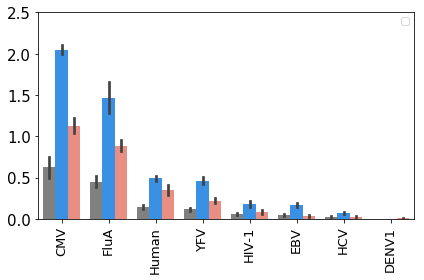

In [13]:
sns.barplot(x='variable',y='value',hue='Dataset',data=df[(df.Chain=='alpha') & (df.variable.isin(antigens))],ci=68,palette=['Gray','Dodgerblue','Salmon'],order=antigens)
plt.xticks(np.arange(len(antigens)),list(map(convert,antigens)),rotation=90,fontsize=13)
plt.ylim([0,2.5])
plt.yticks(fontsize=15)
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.tight_layout()
plt.show()
plt.close()

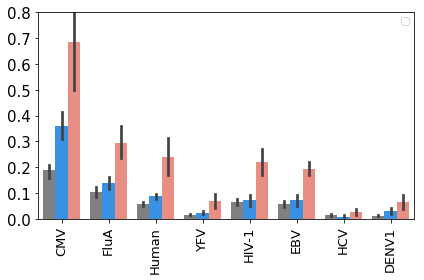

In [14]:
sns.barplot(x='variable',y='value',hue='Dataset',data=df[(df.Chain=='beta') & (df.variable.isin(antigens))],ci=68,palette=['Gray','Dodgerblue','Salmon'],order=antigens)
plt.xticks(np.arange(len(antigens)),list(map(convert,antigens)),rotation=90,fontsize=13)
plt.ylim([0,.8])
plt.yticks(fontsize=15)
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.tight_layout()
plt.show()
plt.close()